# Hoeffding Inequality

Run a computer simulation for flipping 1,000 virtual fair coins. Flip each coin independently 10 times.

Note: this is a first naive implementation, below is a much faster one using binomial distribution...

In [1]:
import random
import numpy as np

In [73]:
def run_experiment():
    coins_flips = []

    # 0 is tail
    # 1 is head
    
    # For 1000 coins
    for _ in range(1000):
        coin_flips = []
        
        # Flip the coin 10 times
        for _ in range(10):
            coin_flips.append(random.choice([0,1]))
        
        coins_flips.append(coin_flips)

    # c1 is the first coin flipped
    c_1 = coins_flips[0]
    ν1 = sum(c_1)/10

    # crand is a coin chosen randomly from the 1,000
    c_rand = random.choice(coins_flips)
    νrand = sum(c_rand)/10

    # cmin is the coin which had the minimum frequency of heads
    coins_heads_frequency = list(map(lambda x: sum(x), coins_flips))
    min_heads_frequency = min(coins_heads_frequency)
    a = np.array(coins_heads_frequency)
    index = np.where(a == min_heads_frequency)[0][0]
    c_min = coins_flips[index]
    νmin = sum(c_min)/10
    
    return (ν1, νrand, νmin)

In [85]:
experiments = []

# Run the experiment 100,000 times in order to get a full distribution of ν1, νrand, and νmin
NUMBER_OF_RUNS = 100000

for _ in range(NUMBER_OF_RUNS):
    experiments.append(run_experiment())

0.00503


## Question 1

In [186]:
avg_νmin = sum(list(map(lambda x: x[2], experiments)))/NUMBER_OF_RUNS
print(f'Average νmin is {avg_νmin}, therefore closest to 0.01: Answer [B]')

NameError: name 'experiments' is not defined

## 1.1-bis Hoeffding Inequality with binomial distribution

In [189]:
import scipy.special

N = 100000
v_first = np.zeros(N)
v_min = np.zeros(N)
v_rand = np.zeros(N)

#Loop starts
for i in range(N):
    n,p = 10, 0.5
    flips = np.random.binomial(n, p, 1000)

    # Indices
    first_coin = 0
    min_coin = np.argmin(flips)
    rand_coin = np.random.randint(0,1000)

    v_first[i] = flips[first_coin]/n
    v_min[i] = flips[min_coin]/n
    v_rand[i] = flips[rand_coin]/n

#Loop ends

print(f'Average νmin is {np.average(v_min)}, therefore closest to 0.01: Answer [B])')



Average νmin is 0.03736299999999999, therefore closest to 0.01: Answer [B])


In [188]:
# Sandbox
n,p = 10, 0.5
flips = np.random.binomial(n, p, 10)
print(flips)

[6 4 7 6 4 2 6 6 4 4]


### 2. Which coin(s) has a distribution of ν that satisfies the (single-bin) Hoeffding Inequality?

> The main point is that once you consider the sample, the probability becomes conditional on how this sample came out, and that could violate the 2e^{-2\epsilon^2N} bound, whereas the probability before a sample was drawn always obeys the bound.

Therefore only c1 and c_rand satisfy: Answer [D]

# Linear Regression

In [4]:
import nbimporter
from hw1 import is_misclassified_point, create_dataset, create_experiment
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Illustration of Linear Regression

In [10]:
f, dataset = create_experiment(100)

In [11]:
# We can find w either using the Pseudo-Inverse
def pseudo_inverse(dataset):
    X = np.array(list(map(lambda x: [1] + x[0], dataset)))

    y = np.array(list(map(lambda x: x[1], dataset)))

    # Using pseudo-inverse
    pseudo_inverse = np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose())

    w = np.dot(pseudo_inverse, y)
    
    return w

w = pseudo_inverse(dataset)
print(w)

[0.39802354 0.2636148  1.24667411]


In [12]:
# Or we can use Scikit Linear Regression
import numpy as np
from sklearn.linear_model import LinearRegression

X = np.array(list(map(lambda x: [1] + x[0], dataset)))

y = np.array(list(map(lambda x: x[1], dataset)))

reg = LinearRegression().fit(X, y)

sci_w = reg.coef_
sci_w[0] = reg.intercept_
print(sci_w)

reg.score(X,y)

[0.39802354 0.2636148  1.24667411]


0.46864097866442167

In [13]:
# Apply PLA on Linear Regression weights, using them as initial vector
pla_w = w

misclassified_points = list(filter(lambda x: is_misclassified_point(pla_w, x), dataset))

i = 0
while len(misclassified_points) > 0:
    # Pick a random misclassified point
    data = random.sample(misclassified_points, 1)[0]

    # Apply PLA iteration
    pla_w = pla_w + np.dot(data[1], [1, data[0][0], data[0][1]])

    misclassified_points = list(filter(lambda x: is_misclassified_point(pla_w, x), dataset))
    i += 1
    
print(i)
print(pla_w)

54
[2.39802354 1.09799609 5.84751276]


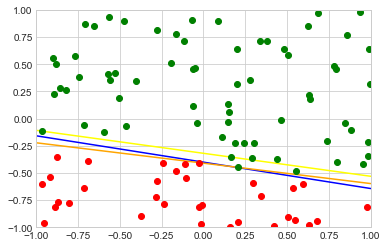

In [16]:
plt.axis([-1, 1, -1, 1])

x = np.linspace(-1, 1, 2)
plt.plot(x, f(x), color='blue')

def g(x):
    y = -(w[1]*x+w[0])/w[2]
    return y

plt.plot(x, g(x), color='yellow')

def pla_g(x):
    y = -(pla_w[1]*x+pla_w[0])/pla_w[2]
    return y

plt.plot(x, pla_g(x), color='orange')

for data in dataset:
    point = data[0]
    output = data[1]
    plt.plot(point[0], point[1],  'go' if output > 0 else 'ro')

### Question 5

In [43]:
experiments = []

N = 100

#  Repeat the experiment 1000 times and take the average
for _ in range(1000):
    f, dataset = create_experiment(N)
    
    # Use Linear Regression to find g
    w = pseudo_inverse(dataset)
    
    # evaluate Ein, the fraction of in-sample points which got classified incorrectly
    misclassified_points = list(filter(lambda data: is_misclassified_point(w, data), dataset))
    Ein = len(misclassified_points)/N
    
    experiments.append([w, Ein, f, dataset])

In [44]:
avg_Ein = np.average(list(map(lambda x: x[1], experiments)))
print(f'Average Ein is {avg_Ein}, there closed to 0.01: Answer C')

Average Ein is 0.03314, there closed to 0.01: Answer C


### Question 6

In [45]:
Eouts = []

#  Repeat the experiment 1000 times and take the average
for i in range(1000):
    # Take the g from Problem 5
    experiment = experiments[i]
    w = experiment[0]
    
    f = experiment[2]
    
    # generate 1000 fresh points and use them to estimate the out-of-sample error Eout of g that you got in Problem 5
    SEPARATED_DATASET_SIZE = 1000
    separated_dataset = create_dataset(f, SEPARATED_DATASET_SIZE)
    
    misclassified_points = list(filter(lambda x: is_misclassified_point(w, x), separated_dataset))

    error_rate = len(misclassified_points)/SEPARATED_DATASET_SIZE
    
    Eouts.append(error_rate)

In [47]:
avg_Eout = np.average(Eouts)
print(f'Average Eout is {avg_Eout}, there closest to 0.01: Answer C')

Average Eout is 0.04286800000000001, there closest to 0.01: Answer C


### Question 7

In [52]:
N = 10

iterations = []

#  Repeat the experiment 1000 times and take the average
for _ in range(1000):
    f, dataset = create_experiment(N)
    
    # Find weights using Linear Regression 
    # use them as a vector of initial weights for the Perceptron Learning Algorithm
    w = pseudo_inverse(dataset)
    
    misclassified_points = list(filter(lambda x: is_misclassified_point(w, x), dataset))
    
    i = 0
    while len(misclassified_points) > 0:
        # Pick a random misclassified point
        data = random.sample(misclassified_points, 1)[0]

        # Apply PLA iteration
        w = w + np.dot(data[1], [1, data[0][0], data[0][1]])

        misclassified_points = list(filter(lambda data: is_misclassified_point(w, data), dataset))
        i += 1
        
    iterations.append(i)

In [53]:
avg_iterations = np.average(iterations)
print(f'Average number of iterations is {avg_iterations}, there closest to 1: Answer A')

Average number of iterations is 3.739, there closest to 1: Answer A


# Nonlinear Transformation

### Question 8

In [93]:
# Generate a training set of N = 1000 points on X = [−1, 1] × [−1, 1] with a uniform probability of picking each x ∈ X
import math

# Consider the target function:
def f(x):
    y = np.sign(x[0]**2 + x[1]**2 - 0.6)
    return y

def create_dataset_with_noise(N, ratio):
    dataset = [];
    
    for _ in range(N):
        # Choose the inputs xn of the data set as random points
        x1, x2 = np.random.uniform(-1,1,2)
        
        
        y = f([x1,x2])

        dataset.append([[x1,x2], y])
        
    # Generate simulated noise 
    # by flipping the sign of the output in a randomly selected 10% subset of the generated training set.
    indices = random.sample(range(N), int(float(N)*ratio))

    for i in indices:
        dataset[i][1] = dataset[i][1] * (-1)
    
    return dataset;

In [95]:
Eins = []

N = 1000
ratio = 0.1

for _ in range(1000):
    dataset = create_dataset_with_noise(N, 0.1)
    
    # Use Linear Regression to find g
    w = pseudo_inverse(dataset)
    
    # evaluate Ein, the fraction of in-sample points which got classified incorrectly
    misclassified_points = list(filter(lambda x: is_misclassified_point(w, x), dataset))
    Ein = len(misclassified_points)/N
    
    Eins.append(Ein)

In [98]:
avg_Ein = np.average(Eins)
print(f'Average Ein is {avg_Ein}, there closest to 0.5: Answer [D]')

Average Ein is 0.501289, there closest to 0.5: Answer [D]


### Question 9

In [162]:
def fi(x):
    y = [1] + x + [x[0] * x[1]] + [x[0]**2] + [x[1]**2]
    return y

N = 1000
noise = 0.1
dataset = create_dataset_with_noise(N, noise)

#  transform the training data into the nonlinear feature vector, using Fi
X = np.array(list(map(lambda x: fi(x[0]), dataset)))

# y vector of labels does not change
y = np.array(list(map(lambda x: x[1], dataset)))

In [163]:
pseudo_inverse = np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose())

w_tild = np.dot(pseudo_inverse, y)

In [164]:
w_a = [-1, -0.05, 0.08, 0.13, 1.5, 1.5]
w_b = [-1, -0.05, 0.08, 0.13, 1.5, 15]
w_c = [-1, -0.05, 0.08, 0.13, 15, 1.5]
w_d = [-1, -1.5, 0.08, 0.13, 0.05, 0.05]
w_e = [-1, -0.05, 0.08, 1.5, 0.15, 0.15]

hypothesis = [w_a, w_b, w_c, w_d, w_e]

In [165]:
# We test other 100 random points which hypothesis agrees the most with our hypothesis
indices = random.sample(range(N), int(float(N)*ratio))

agreements = np.zeros(5)

for i in indices:
    data = dataset[i]
    
    x = data[0]

    for j in range(len(hypothesis)):
        if np.sign(np.dot(hypothesis[j], fi(x))) == np.sign(np.dot(w_tild, fi(x))):
            agreements[j] += 1
    
agreements

array([96., 70., 62., 57., 54.])

The first hypothesis is the closest: Answer [A]

### Question 10

> What is the closest value to the classification out-of-sample error Eout

In [183]:
Eouts = []

# Adapt missclassification to Fi transformation
def is_missclassified(w, data):
    return np.sign(np.dot(w, fi(data[0]))) != data[1]

SEPARATED_DATASET_SIZE = 1000

# Create 1000 times, 1000 new fresh points to get the average error out-of-sample Eout
for _ in range(1000):
    separated_dataset = create_dataset_with_noise(SEPARATED_DATASET_SIZE, noise)

    misclassified_points = list(filter(lambda x: is_missclassified(w_tild, x), separated_dataset))

    error_rate = len(misclassified_points)/SEPARATED_DATASET_SIZE
    Eouts.append(error_rate)


In [185]:
avg_Eout = np.average(Eouts)
print(f'Average Eout is {avg_Eout}, there closest to 0.1: Answer [B]')

Average Eout is 0.12868700000000002, there closest to 0.1: Answer [B]
